In [110]:
import numpy as np
import pandas as pd
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows',500)

In [77]:
#Load the data
rated_bookings_file = './Datasets/rated_bookings_with_location.csv'
rb=pd.read_csv(rated_bookings_file)

#Convert to Datetimes
rb['pickup_date'] = pd.to_datetime(rb['pickup_date'])
rb['last_update_date'] = pd.to_datetime(rb['last_update_date'])
rb['booking_date'] = pd.to_datetime(rb['booking_date'])
rb['rating_date'] = pd.to_datetime(rb['rating_date'])

#Load the bookings
bookings_file = './Datasets/all_bookings2.0.csv'
book=pd.read_csv(bookings_file)


In [78]:
'''Column Names
rb.columns
['booking_id', 'supplier', 'status', 'roundtrip_id', 'name',
       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',
       'total_price', 'total_comission', 'total_driver', 'special_notes',
       'city_of_departure', 'booking_departure', 'booking_destination',
       'route_type', 'route', 'address', 'hotel', 'flight_number',
       'last_update_date', 'booking_date', 'rating_text', 'country',
       'rating_score', 'rating_date', 'vehicle_category', 'in_or_outbound',
       'airport', 'neighborhood', 'days_in_advance', 'day_in_advance_groups',
       'has_been_updated', 'address_lat', 'address_loc']

book.columns
['status', 'supplier', 'booking_id', 'roundtrip_id', 'name',
       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',
       'route_type', 'route', 'total_price', 'total_comission', 'total_driver',
       'special_notes', 'city_of_departure', 'address', 'hotel',
       'flight_number', 'last_update_date', 'booking_date']
'''

"Column Names\nrb.columns\n['booking_id', 'supplier', 'status', 'roundtrip_id', 'name',\n       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',\n       'total_price', 'total_comission', 'total_driver', 'special_notes',\n       'city_of_departure', 'booking_departure', 'booking_destination',\n       'route_type', 'route', 'address', 'hotel', 'flight_number',\n       'last_update_date', 'booking_date', 'rating_text', 'country',\n       'rating_score', 'rating_date', 'vehicle_category', 'in_or_outbound',\n       'airport', 'neighborhood', 'days_in_advance', 'day_in_advance_groups',\n       'has_been_updated', 'address_lat', 'address_loc']\n\nbook.columns\n['status', 'supplier', 'booking_id', 'roundtrip_id', 'name',\n       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',\n       'route_type', 'route', 'total_price', 'total_comission', 'total_driver',\n       'special_notes', 'city_of_departure', 'address', 'hotel',\n       'flight_number', 'last_up

In [115]:
rb['pickup_date']#.dt.year()==2023

0       2014-09-19 21:00:00
1       2014-09-15 22:35:00
2       2014-10-03 13:50:00
3       2014-11-08 18:30:00
4       2014-09-30 03:00:00
                ...        
20118   2024-02-03 04:00:00
20119   2024-02-03 16:00:00
20120   2024-02-03 19:00:00
20121   2024-02-03 17:10:00
20122   2024-02-03 18:55:00
Name: pickup_date, Length: 20123, dtype: datetime64[ns]

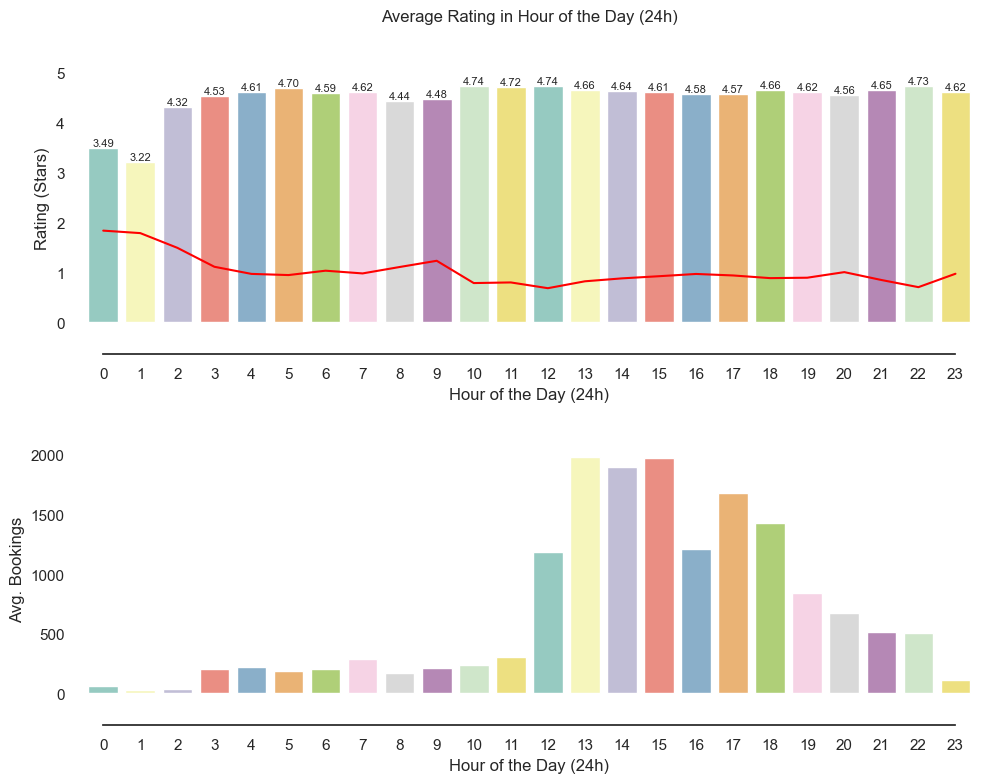

In [296]:
#Ratings per Time of day.

f = plt.figure(figsize=(10,8))
gs = f.add_gridspec(2,1)


#-----------------------
#-----------------------


with sns.axes_style('white'):
    ax=f.add_subplot(gs[0,0])
#-----------------------
    def add_margin(ax,x=0.05,y=0.05):
        # This will, by default, add 5% to the x and y margins. You 
        # can customise this using the x and y arguments when you call it.
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xmargin = (xlim[1]-xlim[0])*x
        ymargin = (ylim[1]-ylim[0])*y
        ax.set_xlim(xlim[0]-xmargin,xlim[1]+xmargin)
        ax.set_ylim(ylim[0]-ymargin,ylim[1]+ymargin)


    rb['pickup_time'].apply(lambda x: str(x).split(':')[0]).value_counts()

    group=rb[ rb['pickup_date'].dt.year>=2022].groupby(rb['pickup_time'].apply(lambda x: int(str(x).split(':')[0])))
    g1=group.agg({'rating_score':['count', 'mean','sum', 'min', 'max', 'std']})
    #print(g1)
    g1.columns= g1.columns.droplevel()

    #sns.set_theme(style='whitegrid')
    sns.lineplot(data=g1,x='pickup_time', y='std', color='red')
    sns.barplot(data=g1, x='pickup_time', hue='pickup_time', legend='auto', y='mean', palette=sns.color_palette('Set3', n_colors=24))

    #Set datalabels
    #sns.set(rc={'figure.figsize':(10,5.5)})
    for i in ax.containers:
        ax.bar_label(i,fmt ='%.2f',fontsize=8)
    plt.title('Average Rating in Hour of the Day (24h)',pad=20)
    plt.legend()
    ax.set(xlabel='Hour of the Day (24h)', ylabel='Rating (Stars)')
    # Update the limits using set_xlim and set_ylim
    add_margin(ax,x=0.00,y=0.1) #Call this after tsplot

    sns.despine(offset=0, trim=True)
    sns.despine(left=True)

    plt.legend([],[], frameon=False)
    #plt.show()

###-----------------------------------------
###-----------------------------------------
###-----------------------------------------
###-----------------------------------------


with sns.axes_style('white'):
    ax1=f.add_subplot(gs[1,0])
#-----------------------
    # More simple Vehicle by Category

    def func_case_vehicle(v):
        if v in ['Limo 8', 'SUV Limo', 'Limo 7']:
            return('Limo')
        if v in ['Sprinter 12', 'Van', 'Minibús de 20 plazas', 'Furgoneta de 14 plazas', 'Furgoneta de 10 plazas','Monovolumen de 7 plazas']:
            return('Van')
        else:
            return v

    book['vehicle_category']=book['vehicle_type'].apply(func_case_vehicle)

    #Convert to Datetimes
    book['pickup_date'] = pd.to_datetime(book['pickup_date'])

    group=book[(book['pickup_date'].dt.year>=2022)&(book['pickup_date'].dt.year<2024)].groupby([book['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), book['pickup_date'].dt.year])
    g1=group.agg({'booking_id':['count']})
    g1.columns= g1.columns.droplevel(0)
    g1=g1.reset_index()
    #print(g1)
    group2=g1.groupby([g1['pickup_time']], as_index=True)
    g2=group2.agg({'count':['mean']})
    g2.columns= g2.columns.droplevel(0)
    g2=g2.reset_index()
    #g2.columns=['pickup_time', 'mean']
    #print(g2)
    #sns.set_theme(style='white')
    #sns.set(rc={'figure.figsize':(10,5)})
    sns.barplot(x=g2['pickup_time'],y=g2['mean'],hue=g2['pickup_time'] , palette=sns.color_palette('Set3', n_colors=24))
    plt.xticks(g2['pickup_time'])
    #plt.title('Average Bookings in each Hour of the Day (24h)')
    #plt.legend(title='Month')
    ax1.set(xlabel='Hour of the Day (24h)', ylabel='Avg. Bookings')
    # Update the limits using set_xlim and set_ylim
    add_margin(ax1,x=0.00,y=0.1) #Call this after tsplot
    ax1.axes.get_yaxis().set_visible(True)
    sns.despine(offset=5, trim=True)
    sns.despine(left=True)
    plt.legend([],[], frameon=False)

    #plt.show()

f.tight_layout()

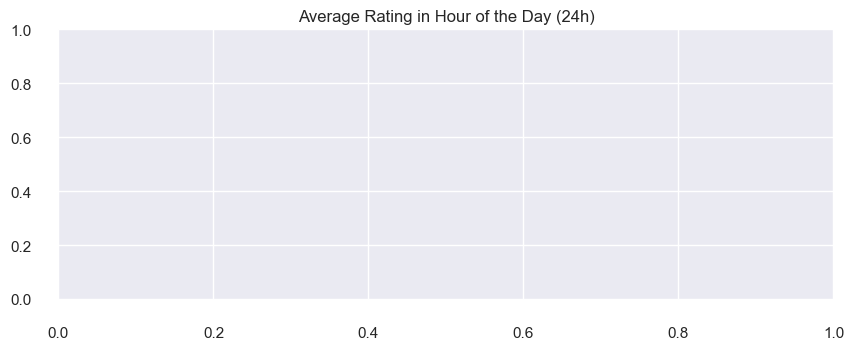

In [204]:





g1=group.agg({'booking_id':['count']})

#print(g1)
g1.columns= g1.columns.droplevel()

sns.set_theme(style='whitegrid')
ax=sns.lineplot(data=g1,x='pickup_time', y='std', color='red')
#ax=sns.barplot(data=g1, x='pickup_time', hue='pickup_time', legend='auto', y='mean', palette=sns.color_palette('Set3', n_colors=24))

#Set datalabels
sns.set(rc={'figure.figsize':(10,3.5)})
for i in ax.containers:
    ax.bar_label(i,fmt ='%.2f',fontsize=8)
plt.title('Average Rating in Hour of the Day (24h)')
#plt.legend(title='Month')
ax.set(xlabel='Hour of the Day (24h)', ylabel='Rating (Stars)')
# Update the limits using set_xlim and set_ylim
add_margin(ax,x=0.05,y=0.05) #Call this after tsplot
sns.despine(offset=10, trim=True)
sns.despine(left=True)
plt.show()

    pickup_time    mean
0             0    58.5
1             1    28.0
2             2    36.0
3             3   203.5
4             4   220.5
5             5   188.5
6             6   206.5
7             7   287.0
8             8   171.0
9             9   210.0
10           10   239.0
11           11   305.5
12           12  1185.5
13           13  1984.0
14           14  1895.5
15           15  1973.5
16           16  1213.0
17           17  1677.5
18           18  1426.5
19           19   840.0
20           20   674.5
21           21   512.5
22           22   504.5
23           23   115.5


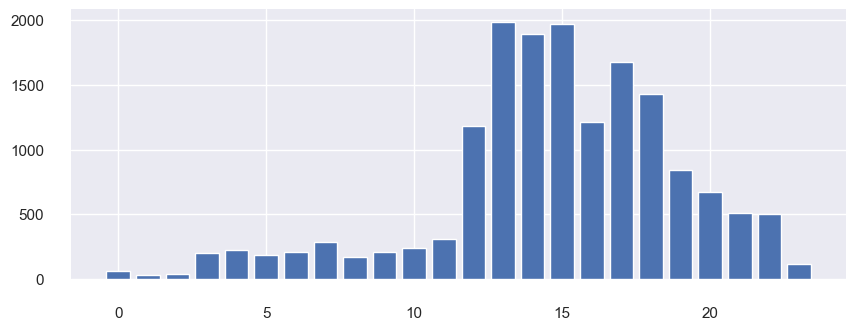

In [219]:
# More simple Vehicle by Category

def func_case_vehicle(v):
    if v in ['Limo 8', 'SUV Limo', 'Limo 7']:
        return('Limo')
    if v in ['Sprinter 12', 'Van', 'Minibús de 20 plazas', 'Furgoneta de 14 plazas', 'Furgoneta de 10 plazas','Monovolumen de 7 plazas']:
        return('Van')
    else:
        return v

book['vehicle_category']=book['vehicle_type'].apply(func_case_vehicle)

#Convert to Datetimes
book['pickup_date'] = pd.to_datetime(book['pickup_date'])

group=book[(book['pickup_date'].dt.year>=2022)&(book['pickup_date'].dt.year<2024)].groupby([book['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), book['pickup_date'].dt.year])
g1=group.agg({'booking_id':['count']})
g1.columns= g1.columns.droplevel(0)
g1=g1.reset_index()
#print(g1)
group2=g1.groupby([g1['pickup_time']], as_index=True)
g2=group2.agg({'count':['mean']})
g2.columns= g2.columns.droplevel(0)
g2=g2.reset_index()
print(g2)

plt.bar(g2['pickup_time'],g2['mean'])
#ax.set(xticks=g2['pickup_time'])


#Set datalabels
sns.set(rc={'figure.figsize':(10,3.5)})
for i in ax.containers:
    ax.bar_label(i,fmt ='%.2f',fontsize=8)
#plt.title('Average Rating in Hour of the Day (24h)')
#plt.legend(title='Month')
ax.set(xlabel='Hour of the Day (24h)', ylabel='Rating (Stars)')
# Update the limits using set_xlim and set_ylim
#add_margin(ax,x=0.05,y=0.05) #Call this after tsplot

sns.despine(offset=10, trim=True)
sns.despine(left=True)


plt.show()


In [80]:
#business Volume

In [81]:
rb['pickup_time']

0        21:00
1        22:35
2        13:50
3        18:30
4        03:00
         ...  
20118    04:00
20119    16:00
20120    19:00
20121    17:10
20122    18:55
Name: pickup_time, Length: 20123, dtype: object